In [1]:
import pickle

In [3]:
with open('boothremote_data.pck','r') as picklefile:
    boothremote_data = pickle.load(picklefile)
        
boothremote_to_station, station_to_boothremotes, boothremote_to_time_series = boothremote_data

In [4]:
boothremote_to_station.items()[0]

(('R110', 'R027'), 'WALL ST')

In [5]:
from pprint import pprint
sample_dict = dict(station_to_boothremotes.items()[:5])
pprint(sample_dict)

{'22 AVE-BAY PKY': [('N553', 'R422')],
 '57 ST-7 AVE': [('A010', 'R080'), ('A011', 'R080')],
 'BOYD-88 ST': [('N133', 'R384')],
 'PATH WTC': [('PTH08', 'R540')],
 'TREMONT AVE': [('N213', 'R154'), ('N214', 'R154')]}


In [6]:
key, value = boothremote_to_time_series.items()[0]
print 'key',key #booth and remote tuple
print 'value', value[:4] #timeseries daily counts

key ('R110', 'R027')
value [[datetime.datetime(2014, 5, 24, 0, 0), 3781], [datetime.datetime(2014, 5, 25, 0, 0), 3518], [datetime.datetime(2014, 5, 26, 0, 0), 3367], [datetime.datetime(2014, 5, 27, 0, 0), 11345]]


In [7]:
from collections import Counter
# to create a dic, key=station, value=timeseries. wa are rolling up boothremotes to stations

station_to_time_series = {}

for station, station_brs in station_to_boothremotes.iteritems(): #better practice to use iteritems() than items() because it is more efficient
    daily_counts = Counter()
    
    for br in station_brs:
        # boothremote_to_time_series[br] is a timeseries
        time_series = boothremote_to_time_series[br]
        
        for date, count in time_series:
            daily_counts[date] += count
            
        #daily_counts is a Counter, but dail_counts.items() is a lis of (datetime,count) tuples.
        
        station_to_time_series[station] = sorted(daily_counts.items())

In [8]:

key, value = station_to_time_series.items()[0]
print 'key', key
print 'val sample', value[:5]

key BOYD-88 ST
val sample [(datetime.datetime(2014, 5, 24, 0, 0), 1047), (datetime.datetime(2014, 5, 25, 0, 0), 844), (datetime.datetime(2014, 5, 26, 0, 0), 1001), (datetime.datetime(2014, 5, 27, 0, 0), 2408), (datetime.datetime(2014, 5, 28, 0, 0), 2423)]


In [9]:
# collapse entier subway ridership into two time series
# first: timeseris by day
daily_full_mta_counts = Counter()
#second: timeseries by week
weekly_full_mta_counts = Counter()

for station, time_series in station_to_time_series.iteritems():
    for date, count in time_series:
        daily_full_mta_counts[date] += count
        
        # date.isocalendar() Return a 3-tuple containing ISO year, week number, and weekday.
        week = date.isocalendar()[1]
        weekly_full_mta_counts[week] += count
        #
daily_full_mta_time_series = sorted(daily_full_mta_counts.items())
weekly_full_mta_time_series = sorted(weekly_full_mta_counts.items())


In [10]:
pprint(weekly_full_mta_time_series)

[(21, 6029049),
 (22, 33153328),
 (23, 36559260),
 (24, 36157028),
 (25, 36514997),
 (26, 36090151),
 (27, 30803343),
 (28, 34549534),
 (29, 34689273),
 (30, 35006235),
 (31, 34330818),
 (32, 34554591),
 (33, 33324691),
 (34, 32939197),
 (35, 26454170)]


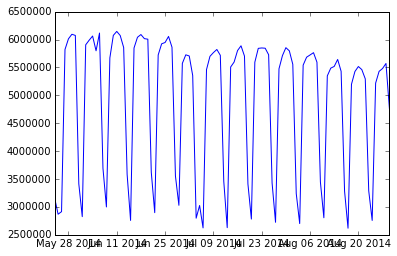

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

x,y = [],[]
for date, count in daily_full_mta_time_series:
    x.append(date)
    y.append(count)
    
plt.plot(x,y)

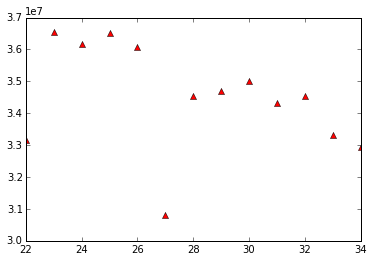

In [12]:
# let's plot the weekly timeseries
x,y = [],[]
for date, count in weekly_full_mta_time_series:
    x.append(date)
    y.append(count)

#remove first and last week, which are not full weeks due to cal numberings

x.pop(0)
x.pop()
y.pop(0)
y.pop()

plt.plot(x,y, "r^")

In [13]:
from sklearn.linear_model import LinearRegression
import numpy as np

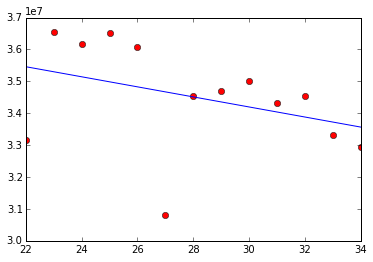

In [14]:
X = np.asarray(x).reshape(len(x),1)
Y = np.asarray(y).reshape(len(y),1)

regressor = LinearRegression(fit_intercept=True).fit(X,Y)

Y_fit = regressor.predict(X)

plt.plot(X,Y, "ro")
plt.plot(X,Y_fit)


In [15]:
print regressor.coef_
observed_slope = regressor.coef_[0,0]
print observed_slope

[[-157702.2967033]]
-157702.296703


In [16]:
# hypotheisi is the ridership actually goin down
import random
mu = np.mean(y)
sigma =np.std(y)
simulated_slopes = []
extreme_slopes =[]

for simulation in range(5000):
    simulated_weekly_counts = []
    
    for i in range (13):
        simulated_weekly_counts.append(random.normalvariate(mu,sigma))
        
    sim_Y = np.asarray(simulated_weekly_counts).reshape(len(simulated_weekly_counts),1)
    sim_regressor = LinearRegression(fit_intercept=True).fit(X,sim_Y)
    sim_y_fit = sim_regressor.predict(X)
    sim_slope = sim_regressor.coef_[0,0]
    simulated_slopes.append(sim_slope)
    if sim_slope <= observed_slope:
        extreme_slopes.append(sim_slope)

In [17]:
print float(len(extreme_slopes)) / len(simulated_slopes)

0.0966


In [18]:
regressor.score(X,Y)

0.13635529671801094

In [83]:
test_counter =Counter()
my_dict ={}

my_dict["a"]=1
# print my_dict
test_counter["b"] = 0
#print test_counter["a"]
#print test_counter.items()
#my_dict["non_existent_key"] this gives a keyerro
print test_counter["non_existent_keys"], test_counter["b"] 


0 0


In [51]:
# collapse timeseries by month
station_to_month_series = {}
for station, time_series in station_to_time_series.iteritems():
    monthly_count = Counter()
    for date, count in time_series:
        #print date
        month = date.month
        monthly_count[month] += count
    station_to_month_series[station] = sorted(monthly_count.items())
        



In [21]:

key, value = station_to_month_series.items()[3]
print 'key', key
print 'val sample', value

key 22 AVE-BAY PKY
val sample [(5, 9964), (6, 39002), (7, 36230), (8, 33541)]


In [22]:
hotel_oc = {1:.77, 2:.77, 3:.86, 4:.92, 5:.94, 6:.93, 7:.91, 8:.94, 9:.92, 10:.94}
hotel_cost = {1:237.16, 2:231.72, 3:248.81, 4:294.76, 5:319.1, 6:302.74, 7:259.14, 8:263.74, 9:361.86, 10:357.08}

In [23]:
print hotel_oc

{1: 0.77, 2: 0.77, 3: 0.86, 4: 0.92, 5: 0.94, 6: 0.93, 7: 0.91, 8: 0.94, 9: 0.92, 10: 0.94}


In [24]:
for m,c in value:
    print m,c

5 9964
6 39002
7 36230
8 33541


In [52]:
torist_stations ={}
for key, value in station_to_month_series.items():
    try:
        torist_stations[key]=Torsityness(value)
    except:
        print key
    

NYC & CO - 7 AV
ELTINGVILLE PK
LGA AIRPORT CTB
JFK JAMAICA CT2
METROCARD VAN-2
METROCARD VAN-1
2 BDWY CUST SRV
METROCARD VAN-3
LIB-HEMPSTEAD
WEST COUNTY CTR
SOUTH FERRY
METROCARD BUS 1
METROCARD BUS 2


/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:69: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


In [58]:
torist_list =[]
for key, value in station_to_month_series.items():
    try:
        torist_list.append(Torsityness(value))
    except:
        print key

NYC & CO - 7 AV
ELTINGVILLE PK
LGA AIRPORT CTB
JFK JAMAICA CT2
METROCARD VAN-2
METROCARD VAN-1
2 BDWY CUST SRV
METROCARD VAN-3
LIB-HEMPSTEAD
WEST COUNTY CTR
SOUTH FERRY
METROCARD BUS 1
METROCARD BUS 2


In [56]:
torist_list_cost =[]
for key, value in station_to_month_series.items():
    try:
        torist_list_cost.append(Torsitprice(value))
    except:
        print key

NYC & CO - 7 AV
ELTINGVILLE PK
LGA AIRPORT CTB
JFK JAMAICA CT2
METROCARD VAN-2
METROCARD VAN-1
2 BDWY CUST SRV
METROCARD VAN-3
LIB-HEMPSTEAD
WEST COUNTY CTR
SOUTH FERRY
METROCARD BUS 1
METROCARD BUS 2


In [64]:
torist_cost_dict ={}
for key, value in station_to_month_series.items():
    try:
        torist_cost_dict[key]=Torsitprice(value)
    except:
        print key

NYC & CO - 7 AV
ELTINGVILLE PK
LGA AIRPORT CTB
JFK JAMAICA CT2
METROCARD VAN-2
METROCARD VAN-1
2 BDWY CUST SRV
METROCARD VAN-3
LIB-HEMPSTEAD
WEST COUNTY CTR
SOUTH FERRY
METROCARD BUS 1
METROCARD BUS 2


In [66]:
sorted(torist_cost_dict.items())

[('1 AVE', 0.43841315749373744),
 ('103 ST', 0.4522603102576831),
 ('103 ST-CORONA', 0.51402741839256605),
 ('104 ST', 0.50119805440104548),
 ('110 ST', 0.41858413569574293),
 ('110 ST-CATHEDRL', 0.40238396013680389),
 ('110 ST-CPN', 0.45791796139898944),
 ('111 ST', 0.49624486103324283),
 ('116 ST', 0.46628638384499665),
 ('116 ST-COLUMBIA', 0.64760789828086485),
 ('121 ST', 0.4867395924775717),
 ('125 ST', 0.45655171686572471),
 ('135 ST', 0.46913148856918852),
 ('137 ST-CITY COL', 0.43601971524483873),
 ('138 ST-3 AVE', 0.48816776422346753),
 ('138 ST-GR CONC', 0.51835559344261983),
 ('14 ST', 0.42642501895522777),
 ('14 ST-6 AVE', 0.46143800779277988),
 ('14 ST-UNION SQ', 0.48274241752079539),
 ('145 ST', 0.48629155017075065),
 ('148 ST-LENOX', 0.51557623442037648),
 ('149 ST-3 AVE', 0.4293525648036135),
 ('149 ST-GR CONC', 0.53975926238184901),
 ('14TH STREET', 0.49024685386089262),
 ('15 ST-PROSPECT', 0.42506293213314894),
 ('155 ST', 0.44836389658742937),
 ('157 ST', 0.481666529

In [28]:
torist_stations.items()

[]

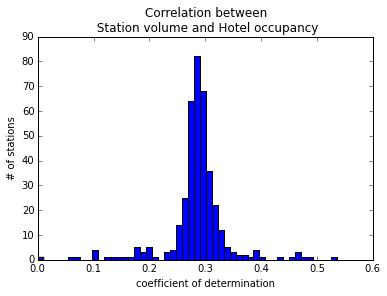

In [61]:
plt.hist(torist_list,bins = 50)
plt.ylabel('# of stations')
plt.xlabel('coefficient of determination')
plt.title('Correlation between \n Station volume and Hotel occupancy')

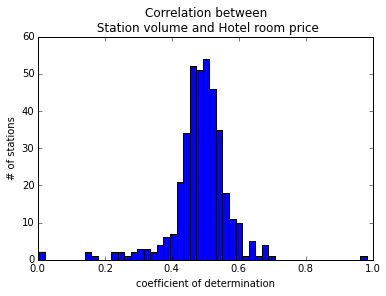

In [62]:
#torist_list_cost
plt.hist(torist_list_cost, bins = 50)
plt.ylabel('# of stations')
plt.xlabel('coefficient of determination')
plt.title('Correlation between \n Station volume and Hotel room price')

In [54]:
def Torsityness(value):
    Ocu =[]
    Count =[]
    for m,c in value:
        Ocu.append(hotel_oc[m])
        Count.append(c)
    #print Count, Ocu
    Ocu = np.asarray(Ocu).reshape(len(Ocu),1)
    Count = np.asarray(Count).reshape(len(Count),1)
    toc_reg= LinearRegression(fit_intercept=True).fit(Count,Ocu)
    toristy=toc_reg.score(Count,Ocu)
    return toristy

In [55]:
def Torsitprice(value):
    Ocu =[]
    Count =[]
    for m,c in value:
        Ocu.append(hotel_cost[m])
        Count.append(c)
    #print Count, Ocu
    Ocu = np.asarray(Ocu).reshape(len(Ocu),1)
    Count = np.asarray(Count).reshape(len(Count),1)
    toc_reg= LinearRegression(fit_intercept=True).fit(Count,Ocu)
    toristy=toc_reg.score(Count,Ocu)
    return toristy

[0.94, 0.93, 0.91, 0.94] [13001, 52634, 51563, 46520]


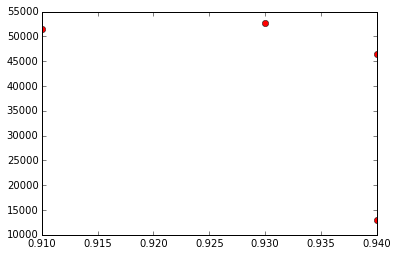

In [43]:
Ocu =[]
Count =[]
for m,c in value:
    Ocu.append(hotel_oc[m])
    Count.append(c)
plt.plot(Ocu,Count, "ro")
print Ocu, Count

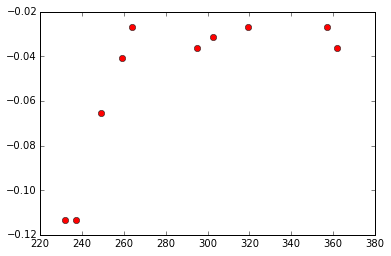

In [38]:
import math
ocu = []
cost =[]
for key in hotel_cost.keys():
    cost.append(hotel_cost[key])
    ocu.append(math.log10(hotel_oc[key]))
#     ocu.append(math.exp(hotel_oc[key]))
#     ocu.append(hotel_oc[key])


plt.plot(cost,ocu, "ro")    

In [37]:
import math
math.log(3)

1.0986122886681098

In [36]:
hotel_oc1 = [.88, .90,.77, .77, .86, .92, .94, .93, .91, .94, .92, .94]
hotel_cost1 = [316.31, 351.85, 237.16, 231.72, 248.81, 294.76, 319.1, 302.74, 259.14, 263.74, 361.86, 357.08]
print len(hotel_oc1)
print len(hotel_cost1)

12
12


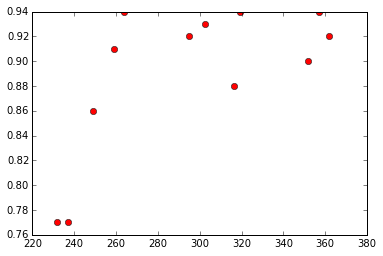

In [44]:
plt.plot(hotel_cost1,hotel_oc1, "ro")    

In [45]:
xc = np.asarray(hotel_cost1).reshape(12,1)
oc = np.asarray(hotel_oc1).reshape(12,1)
reg = LinearRegression(fit_intercept=True).fit(xc,yc)

Y_fit = reg.predict(xc)

plt.plot(xc,oc, "ro")
plt.plot(xc,Y_fit)
reg.score(xc,oc)

NameError: name 'yc' is not defined

In [ ]:
np.asarray(range(3))

In [47]:
money= xc

In [ ]:
print money

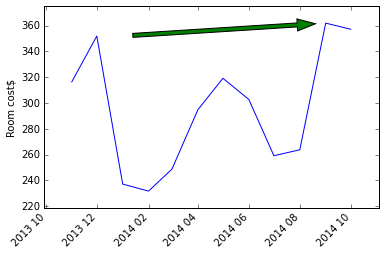

In [48]:
from matplotlib.dates import DateFormatter
monthFormatter = DateFormatter('%Y %m')
fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
ax.xaxis.set_major_formatter(monthFormatter)
ax.xaxis_date()
ax.autoscale_view()

#yearmonth=['Nov 2013','Dec 2013', 'Jan 2014', 'Feb 2014', 'Mar 2014', 'Apr 2014', 'May 2014', 'Jun 2014', 'Jul 2014', 'Aug 2014','Sep 2014','Oct 2014']
plt.plot(yearmonth,money)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.margins(0.1)
plt.ylabel('Room cost$')
plt.annotate('', xy=(yearmonth[10], money[10]), xytext=(yearmonth[2], money[1]),
            arrowprops=dict(facecolor='green', shrink=0.05),
            )

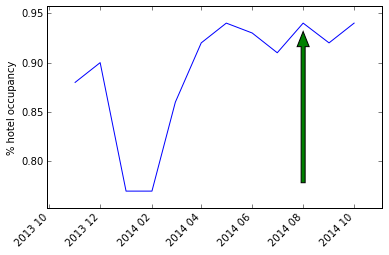

In [49]:
from matplotlib.dates import DateFormatter
monthFormatter = DateFormatter('%Y %m')
fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
ax.xaxis.set_major_formatter(monthFormatter)
ax.xaxis_date()
ax.autoscale_view()

#yearmonth=['Nov 2013','Dec 2013', 'Jan 2014', 'Feb 2014', 'Mar 2014', 'Apr 2014', 'May 2014', 'Jun 2014', 'Jul 2014', 'Aug 2014','Sep 2014','Oct 2014']
plt.plot(yearmonth,oc)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.margins(0.1)
plt.ylabel('% hotel occupancy')
plt.annotate('', xy=(yearmonth[9], oc[9]), xytext=(yearmonth[9], oc[2]),
            arrowprops=dict(facecolor='green', shrink=0.05),
            )

In [34]:
datetime.datetime(2013,11,1,0,0)

datetime.datetime(2013, 11, 1, 0, 0)

In [33]:
index=date_range('1/1/2000', periods=1000)

NameError: name 'date_range' is not defined

In [32]:
import datetime
yearmonth = [datetime.datetime(2013, 11, 1),datetime.datetime(2013, 12, 1),datetime.datetime(2014, 1, 1),datetime.datetime(2014, 2, 1),datetime.datetime(2014, 3, 1),datetime.datetime(2014, 4, 1),datetime.datetime(2014, 5, 1),datetime.datetime(2014, 6, 1),datetime.datetime(2014, 7, 1),datetime.datetime(2014, 8, 1),datetime.datetime(2014, 9, 1),datetime.datetime(2014, 10, 1)]


In [ ]:
datetime(year, month, day[, hour[, minute[, second[, microsecond[,tzinfo]]]]])

The year, month and day arguments are required. tzinfo may be None, or an
instance of a tzinfo subclass. The remaining arguments may be ints or longs.
date_list